In [1]:
'Expt alpha-3'
%load_ext autoreload
%autoreload 2
from snippets.loader import *
# from data.MNIST.load_mnist import *

device = 'cpu' if torch.cuda.is_available() else 'cpu'

trndata = loaddill('mnist.train.16.data') + loaddill('mnist.train.4.data')
valdata = loaddill('mnist.val.16.data') + loaddill('mnist.val.4.data')
size = trndata[0][0].shape
id_cat = {str(i):i for i in range(10)}

channel_mapping = {v+1:k for k,v in id_cat.items()}
channel_mapping[0] = 'background'
id_mapping = {v:k for k,v in channel_mapping.items()}
nChannels = len(channel_mapping)

logger.info(f'Channel to Object: {channel_mapping}')
logger.info(f'Object to Channel: {id_mapping}')

print(f'Train: {len(trndata)}\tVal: {len(valdata)}\nSize {size}\n{len(id_cat)} Classes')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
logger.info(f'Using device:`{device}`'.upper())

ix = randint(len(trndata))
a,b,c = trndata[ix]
show(a, texts=c, bbs=b, th=1, sz=5); plt.show()

2020-03-15 22:50:24.663 | INFO     | __main__:<module>:19 - Channel to Object: {1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 0: 'background'}
2020-03-15 22:50:24.664 | INFO     | __main__:<module>:20 - Object to Channel: {'0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, 'background': 0}
2020-03-15 22:50:24.665 | INFO     | __main__:<module>:25 - USING DEVICE:`CUDA`


Train: 4000	Val: 400
Size (100, 100)
10 Classes


<Figure size 500x500 with 1 Axes>

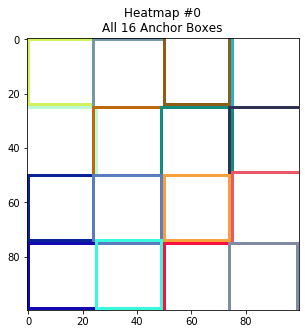

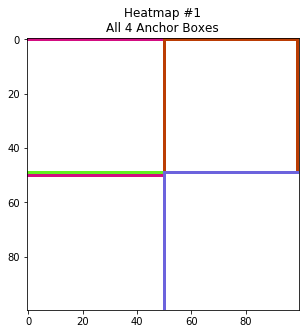

In [11]:
Blank = lambda shape: (255*np.ones(shape)).astype(np.uint8)
def show_anchor_boxes(ix, heatmap_info, jitter=1, ax=None):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    bbs = []
    for r in range(R):
        for c in range(C):
            bbs.append(BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h))
    show(Blank((H,W)), bbs=[bb.jitter(jitter) for bb in bbs], grid=True, ax=ax,
         bb_colors='random', sz=5, th=1, title=f'Heatmap #{ix}\nAll {R*C} Anchor Boxes')

R,C = 4,4
H,W = size
sub_h,sub_w = H/4, W/4
sub_crop_scale = 1.05
stride_h, stride_w = int((H-sub_h)/(R-1)), int((W-sub_w)/(C-1))
heatmap_info1 = R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w

R,C = 2,2
H,W = size
sub_h,sub_w = H/2, W/2
sub_crop_scale = 1.05
stride_h, stride_w = int((H-sub_h)/(R-1)), int((W-sub_w)/(C-1))
heatmap_info2 = R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w

# heatmap_infos = [heatmap_info1]
heatmap_infos = [heatmap_info1, heatmap_info2]
[show_anchor_boxes(ix, hm_inf) for ix, hm_inf in enumerate(heatmap_infos)]; 

In [3]:
from torch.nn import functional as F
jitter = lambda L,th: [bb.jitter(th) for bb in L]
flatten = lambda L: [y for x in L for y in x]
def IOU(b1, b2):
    x,y,X,Y = b1
    a,b,A,B = b2
    assert x<=X and y<=Y and a<=A and b<=B
    A_b1 = (X-x)*(Y-y)
    A_b2 = (A-a)*(B-b)
    xa, ya = max(x,a), max(y,b)
    xb, yb = min(X,A), min(Y,B)
    intersection = max(0,(xb-xa)) * max(0,(yb-ya))
    union = A_b1 + A_b2 - intersection
    return intersection / union
def BBsClssToHMs(bbs, objs, heatmap_info, min_iou_threshold=0.0) -> ['RxCx(1+NCls)','RxCx4*(NCls)']:
    'returns 2 arrays - one for classification task and one for regression task'
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    clss_map, regr_map = np.zeros((R,C,1+len(id_cat))).astype(np.float32), np.zeros((R,C,4*(1+len(id_cat)))).astype(np.float32)
    ignore_ancs = []
    for bb, obj in zip(bbs, objs):
        bb = BB(bb)
        clss = np.zeros((R,C))
        regr = np.zeros((R,C,4))
        for r in range(R):
            for c in range(C):
                anc = anchor_box = BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h)
                iou = IOU(bb, anc)
                if iou <= min_iou_threshold: continue
                dx, dy = anc.x - bb.x, anc.y - bb.y
                dX, dY = anc.X - bb.X, anc.Y - bb.Y
                delta = dx/sub_w, dy/sub_h, dX/sub_w, dY/sub_h
                delta = dx/sub_w, dy/sub_h, dX/sub_w, dY/sub_h
                if any([d**2>1 for d in delta]): continue
                clss[r,c] = iou
                regr[r,c] = delta
                ignore_ancs.append((r,c))
        cls_channel_id = id_mapping[obj]
        clss_map[...,cls_channel_id] += clss
        regr_map[...,cls_channel_id*4:(1+cls_channel_id)*4] += regr

    duplicates = set([anc for anc in ignore_ancs if ignore_ancs.count(anc) > 1])# print(ignore_ancs)
    for r in range(R):
        for c in range(C):
            if (r,c) not in duplicates: continue
            clss_map[r,c,:] = 0
            regr_map[r,c,:] = 0
    regr_map[...,0] = np.clip(1 - regr_map.sum(-1), 0, 1)
    return clss_map, regr_map
def HMsToBBsClss(clss_map, regr_map, heatmap_info, threshold=0.1, debug=True):
    if len(clss_map.shape) == 4 and len(clss_map) == 1:
        clss_map = clss_map[0]
        regr_map = regr_map[0]
    assert len(clss_map.shape) == 3, f'Please pass tensor of shape R x C x (1+NCls) currently passed - {clss_map.shape}'
    assert len(regr_map.shape) == 3, f'Please pass tensor of shape R x C x 4*NCls currently passed - {regr_map.shape}'
    clss_map = F.softmax(clss_map, dim=-1)
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    if isinstance(clss_map, torch.Tensor):
        clss_map = clss_map.cpu().detach().numpy()
        regr_map = regr_map.cpu().detach().numpy()
    bbs, objs, confs, ancs = [], [], [], []
    for channel_ix in range(clss_map.shape[-1]):
        if channel_ix == 0: continue
        clss_id = channel_mapping[channel_ix]
        clss = clss_map[...,channel_ix]
        clss = clss > threshold
        if not clss.sum(): continue # no object was found in this channel
        rs, cs = np.nonzero(clss)
        regr = regr_map[...,channel_ix*4:(1+channel_ix)*4]
        # print(regr)
        for r,c in zip(rs, cs):
            anc = anchor_box = BB(c*stride_w, r*stride_h, c*stride_w+sub_w, r*stride_h+sub_h)
            dx,dy,dX,dY = regr[r,c]
            dx,dy,dX,dY = dx*sub_w, dy*sub_h, dX*sub_w, dY*sub_h
            corrected_bb = BB(anc.x-dx, anc.y-dy, anc.X-dX, anc.Y-dY)
            conf = clss_map[r,c,channel_ix]
            if debug:
                logger.info(f'Object: `{clss_id}` found at Channel# {channel_ix}')
                logger.info(f'Found object at location: {(r,c)}')
                logger.info('Anchor: {}\tDelta: {}\tCorrected: {}\n'.format(anc, delta, corrected_bb))
            bbs.append(corrected_bb)
            objs.append(clss_id)
            confs.append(conf)
            ancs.append(anchor_box)
    return bbs, objs, confs, ancs
def HMsToBBsClss_multiple_hm_infos(clss_maps, regr_maps, heatmap_infos, threshold=0.1, debug=True):
    bbs, objs, confs, ancs = [], [], [], []
    for hx, (clss_map, regr_map, heatmap_info) in enumerate(zip(clss_maps, regr_maps, heatmap_infos)):
        if debug: logger.info(f'Searching in heatmap# {hx}')
        _bbs, _objs, _confs, _ancs = HMsToBBsClss(clss_map, regr_map, heatmap_info, threshold, debug)
        for x,_x in zip([bbs, objs, confs, ancs], [_bbs, _objs, _confs, _ancs]): x.extend(_x)
    return bbs, objs, confs
def decode_objects(im, clss, regr, heatmap_infos, threshold=0.1, debug=False):
    assert all([isinstance(i, list) for i in [clss, regr, heatmap_infos]])
    assert len(clss)==len(regr)==len(heatmap_infos)
    bbs, objs, confs, ancs = [], [], [], []
    _R,_C = 1, len(heatmap_infos)
    fig, ax = plt.subplots(_R,_C, figsize=(10,10)); ax=iter(ax.flat)
    for hx, heatmap_info in enumerate(heatmap_infos):
        if debug: logger.info(f'Searching in heatmap# {hx}')
        _bbs, _objs, _confs, _ancs = HMsToBBsClss(clss[hx], regr[hx], heatmap_info, threshold=threshold, debug=debug)
        if not len(_bbs):
            show(1-im[0], ax=next(ax), title=f'No predictions in Heatmap #{hx}')
            continue
        for x,_x in zip([bbs, objs, confs, ancs], [_bbs, _objs, _confs, _ancs]): x.extend(_x)
        bb_colors = flatten(zip([(255,255,0)]*len(_bbs), [(255,0,0)]*len(_ancs)))
        _bbs_ = flatten(zip(_bbs, _ancs))
        _ixs_ = flatten([(i,i) for i in range(len(_bbs))])
        show(1-im[0], bbs=jitter(_bbs_,2), texts=_ixs_, 
             th=1, ax=next(ax), bb_colors=bb_colors, title=f'Heatmap #{hx}', text_sz=10)
    plt.show()
def decode_heatmap(im, clss, regr, heatmap_info):
    fig,ax = plt.subplots(1, 2, figsize=(10,10)); ax = iter(ax.flat)
    show(im[0], sz=4, title=heatmap_info, ax=next(ax))
    show_anchor_boxes(heatmap_info, ax=next(ax))

    fig,ax = plt.subplots(3, 4, figsize=(10,10)); ax = iter(ax.flat)
    for ix in range(clss.shape[-1]):
        title = 'background' if ix==0 else f'Object `{channel_mapping[ix]}`'
        show(clss[...,ix], title=title, sz=2, ax=next(ax))
    plt.show()
def decode_heatmaps(im, clss, regr, heatmap_infos):
    for ix, heatmap_info in enumerate(heatmap_infos):
        decode_heatmap(im, clss[ix], regr[ix], heatmap_info)
        line()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


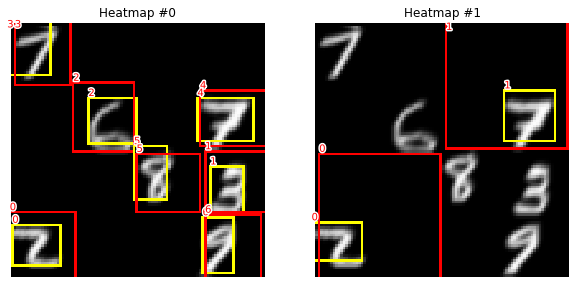

In [14]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox
def from_imgaug_bbs(bbs): return [BB(bb.x1,bb.y1,bb.x2,bb.y2) for bb in bbs]
sometimes = lambda aug, p=0.5: iaa.Sometimes(p, aug)

P = 0.5
aug = iaa.Sequential([
    sometimes(iaa.OneOf([
        iaa.GaussianBlur(sigma=(0, 1.0)),
        iaa.MotionBlur()]),
              p=P),
    iaa.Pad(
            percent=((0.0,0.015), (0.0,0.04), (0.0,0.015), (0.0,0.04)),
            pad_mode='constant',
            pad_cval=0
    ),
    sometimes(iaa.Affine(
            # scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_px=(-10,10), # move by -10 to +10 pixels
            rotate=(-5, 5), # rotate by -x to +x degrees
            shear=(-5, 5), # shear by -x to +x degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=0, # if mode is constant, use a cval between 0 and 255
            mode='constant' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ), p=P),
    sometimes(iaa.ElasticTransformation(alpha=(2, 3), sigma=2, cval=0), p=P),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1), cval=0), p=P),
    iaa.Resize({"height": 100, "width": 100}),
])

class ImageObjects(Dataset):
    def __init__(self, data, iou_thrs=0.0, tfms=None):
        self.data = data
        self.tfms = tfms
        self.thrs = iou_thrs

    def __len__(self): return len(self.data)
    def __getitem__(self, ix):
        im, bbs, objs = self.data[ix]
        if self.tfms:
            im, bbs = self.tfms(images = [im], bounding_boxes = [BoundingBox(*bb) for bb in bbs])
            im, bbs = im[0], from_imgaug_bbs(bbs)
        objs = [str(i) for i in objs]
        clss, regr = [], []
        im = 1 - im/255.
        im = torch.Tensor(im[None]).to(device)
        for hm_info in heatmap_infos:
            clss_, regr_ = BBsClssToHMs(bbs, objs, hm_info, min_iou_threshold=self.thrs)
            clss.append(torch.Tensor(clss_).to(device))
            regr.append(torch.Tensor(regr_).to(device))
        return im, clss, regr

trn = ImageObjects(trndata, tfms=aug)
val = ImageObjects(valdata)
ix = randint(len(trn))
im, clss, regr = trn[ix]
trn = ImageObjects(trndata, iou_thrs=0.0, tfms=None)
val = ImageObjects(valdata)
decode_objects(im, clss, regr, heatmap_infos, debug=False)
# decode_heatmaps(im, clss, regr, heatmap_infos)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


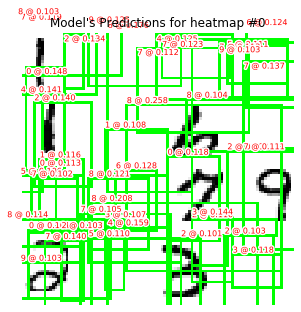

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


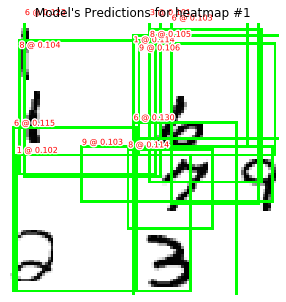

In [5]:
def conv_layer(ni,no,kernel_size,pool_size=None,stride=1,drop=0.2,bn=True,padding='same'):
    padding = 1 if kernel_size==3 else 0
    return nn.Sequential(
        nn.Conv2d(ni, no, kernel_size, stride, padding=padding),
        nn.ReLU(),
        nn.MaxPool2d(pool_size) if pool_size is not None else Identity(),
        nn.BatchNorm2d(no) if bn else Identity(),
        nn.Dropout(drop) if drop is not None else Identity()
    )
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
class Identity(nn.Module):
    def __init__(self)  :   super(Identity, self).__init__()
    def forward(self, x):   return x
class Permute(nn.Module):
    def __init__(self, *args):
        super(Permute, self).__init__()
        self.order = args

    def forward(self, x):
        return x.permute(*self.order)

def get_backbone(**kwargs):
    return nn.Sequential(
        conv_layer(1, 64, 3, pool_size=2),
        conv_layer(64, 128, 3, pool_size=2),
        conv_layer(128, 256, 3, pool_size=2),
        conv_layer(256, 512, 3),
        conv_layer(512, 512, 3)
    )
def classification_head(heatmap_info):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    return nn.Sequential(
        conv_layer(512, 512, 3, pool_size=None),
        nn.Conv2d(512, nChannels, 3, padding=1),
        nn.AdaptiveAvgPool2d((R,C)),
        Permute(0,2,3,1)
    )
def regression_head(heatmap_info):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    return nn.Sequential(
        conv_layer(512, 512, 3, pool_size=None),
        nn.Conv2d(512, 4*(nChannels), 3, padding=1),
        nn.AdaptiveAvgPool2d((R,C)),
        Permute(0,2,3,1)
    )
class objectDetection(nn.Module):
    def __init__(self, heatmap_infos):
        super().__init__()
        self.backbone = get_backbone().to(device)
        self.heatmap_infos = heatmap_infos
        self.classification_heads, self.regression_heads = [], []
        for ix, heatmap_info in enumerate(self.heatmap_infos):
            self.classification_heads.append(classification_head(heatmap_info).to(device))
            self.regression_heads.append(regression_head(heatmap_info).to(device))
        
    def forward(self, x):
        op = self.backbone(x)
        clss, regr = [], []
        for ix, heatmap_info in enumerate(self.heatmap_infos):
            clss.append(self.classification_heads[ix](op))
            regr.append(self.regression_heads[ix](op))
        return clss, regr

model = objectDetection(heatmap_infos).to(device)
trn_dl = DataLoader(trn, shuffle=True, batch_size=10, collate_fn=None)

ims, clss_tr, regr_tr = next(iter(trn_dl))
tr = clss_tr, regr_tr

pr = clss_pr, regr_pr = model(ims)

ix = randint(10)
for hx, heatmap_info in enumerate(heatmap_infos):
    bbs_pr, objs_pr, confs_pr, ancs_pr = HMsToBBsClss(clss_pr[hx][ix], regr_pr[hx][ix], heatmap_info, debug=False)
    infos = [f'{obj} @ {conf:.3f}' for obj, conf in zip(objs_pr, confs_pr)]
    if len(bbs_pr): show(ims[ix,0], bbs=bbs_pr, texts=infos, sz=5, th=1, text_sz=8, title=f'Model\'s Predictions for heatmap #{hx}')


In [6]:
def custom_loss(pr, tr, heatmap_info):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    clss_tr, regr_tr = tr
    clss_pr, regr_pr = pr
    batch_size = len(clss_pr)

    clss_loss = 0
    clss_pr_ = clss_pr.view(-1, R*C, nChannels)
    _, clss_tr_ = clss_tr.view(-1,R*C,nChannels).max(axis=-1)
    for b in range(batch_size):
        clss_loss += nn.CrossEntropyLoss()(clss_pr_[b], clss_tr_[b])
    clss_loss /= (batch_size)
    
    regr_loss = torch.zeros(4, dtype=torch.float32, device=device)
    ctr = 0
    for b in range(batch_size):
        for channel_ix in range(clss_tr.shape[-1]):
            clss = clss_tr[b,...,channel_ix]
            clss = clss > 0
            if not clss.sum(): continue # no object was found in this channel
            rs, cs = torch.nonzero(clss, as_tuple=True)
            
            regr_tr_ = regr_tr[b,...,channel_ix*4:(1+channel_ix)*4]
            regr_pr_ = regr_pr[b,...,channel_ix*4:(1+channel_ix)*4]
            for r,c in zip(rs, cs):
                tr_ = regr_tr_[r, c]
                pr_ = regr_pr_[r, c]
                regr_loss += torch.abs(tr_ - pr_)
                ctr += 1
    if ctr > 0: regr_loss /= ctr
    return clss_loss + 10 * regr_loss.mean()
def custom_loss_multiheatmaps(pr, tr, heatmap_infos):
    clss_tr, regr_tr = tr
    clss_pr, regr_pr = pr
    loss = 0
    for ix, heatmap_info in enumerate(heatmap_infos):
        _pr = clss_pr[ix], regr_pr[ix]
        _tr = clss_tr[ix], regr_tr[ix]
        loss += custom_loss(_pr, _tr, heatmap_info)
    return loss.mean()
def custom_accuracy(pr, tr, heatmap_info):
    R,C,W,H,sub_crop_scale,sub_h,sub_w,stride_h,stride_w = heatmap_info
    clss_tr, regr_tr = tr
    clss_pr, regr_pr = pr
    batch_size = len(clss_pr)
    
    _, clss_pr_ = clss_pr.view(-1, R*C, nChannels).max(axis=-1)
    _, clss_tr_ = clss_tr.view(-1, R*C, nChannels).max(axis=-1)

    acc = (clss_pr_ == clss_tr_).float().mean()
    # mse = ((regr_tru-regr_pred)**2).mean()
    
    regr_loss = torch.zeros(4, dtype=torch.float32, device=device)
    ctr = 0
    for b in range(batch_size):
        for channel_ix in range(clss_tr.shape[-1]):
            clss = clss_tr[b,...,channel_ix]
            clss = clss > 0
            if not clss.sum(): continue # no object was found in this channel
            rs, cs = torch.nonzero(clss, as_tuple=True)
            
            regr_tr_ = regr_tr[b,...,channel_ix*4:(1+channel_ix)*4]
            regr_pr_ = regr_pr[b,...,channel_ix*4:(1+channel_ix)*4]
            for r,c in zip(rs, cs):
                tr_ = regr_tr_[r, c]
                pr_ = regr_pr_[r, c]
                regr_loss += torch.abs(tr_ - pr_)
                ctr += 1
    if ctr > 0: regr_loss /= ctr
    return acc, regr_loss.mean()
def custom_accuracy_multiheatmaps(pr, tr, heatmap_infos):
    clss_acc, regr_mae = 0, 0
    clss_tr, regr_tr = tr
    clss_pr, regr_pr = pr
    for ix, heatmap_info in enumerate(heatmap_infos):
        _pr = clss_pr[ix], regr_pr[ix]
        _tr = clss_tr[ix], regr_tr[ix]
        acc, mae = custom_accuracy(_pr, _tr, heatmap_info)
        clss_acc += acc
        regr_mae += mae
    clss_acc /= (ix+1)
    regr_mae /= (ix+1)
    return clss_acc, regr_mae

In [7]:
info = lambda report: '\t'.join([f'{k}: {v:.3f}' for k,v in report.items()])
def report_metrics(pos, **report):
    elapsed = time.time()-start
    end = report.pop('end','\n')
    elapsed = ' ({:.2f}s - {:.2f}s remaining)'.format(time.time()-start, ((n_epochs-pos)/pos)*elapsed)
    current_iteration = f'EPOCH: {pos:.3f}\t'
    print(current_iteration + info(report) + elapsed, end=end)

In [8]:
import time
!mkdir -p models
n_epochs = 40
# model = objectDetection(heatmap_infos).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
trn_dl = DataLoader(trn, batch_size=8, shuffle=True)

def train_one_batch(model, opt, batch):
    model.train()
    opt.zero_grad()
    ims, tr = batch # tr = truth
    pr = model(ims) # pr = pred
    loss = custom_loss_multiheatmaps(pr, tr, heatmap_infos)
    loss.backward()
    opt.step()
    return loss

start = time.time()
for ex in range(n_epochs):
    for bx, (ims, clss_tr, regr_tr) in enumerate(trn_dl):
        ims, tr = ims, (clss_tr, regr_tr)
        batch = ims, tr
        pos = ex + ((bx+1) / len(trn_dl))
        loss = train_one_batch(model, opt, batch)
        end = '\n' if bx == len(trn_dl)-1 else '\r'
        report_metrics(pos=pos, train_loss=loss, end=end)
        torch.save(model, 'models/object-detection-with-mnist-0.3.pth')
    if ex == 3: opt = optim.Adam(model.parameters(), lr=1e-4)
    if ex ==10: opt = optim.Adam(model.parameters(), lr=1e-5)


/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type objectDetection. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/yyr/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won'

EPOCH: 1.000	train_loss: 5.898 (92.17s - 3594.62s remaining)
EPOCH: 2.000	train_loss: 5.097 (190.87s - 3626.55s remaining)
EPOCH: 3.000	train_loss: 4.412 (295.41s - 3643.35s remaining)
EPOCH: 4.000	train_loss: 4.723 (398.65s - 3587.86s remaining)
EPOCH: 5.000	train_loss: 3.435 (484.77s - 3393.38s remaining)
EPOCH: 6.000	train_loss: 3.993 (568.46s - 3221.25s remaining)
EPOCH: 7.000	train_loss: 3.541 (651.80s - 3072.79s remaining)
EPOCH: 8.000	train_loss: 3.629 (737.04s - 2948.17s remaining)
EPOCH: 9.000	train_loss: 3.276 (817.37s - 2815.38s remaining)
EPOCH: 10.000	train_loss: 3.229 (897.89s - 2693.66s remaining)
EPOCH: 11.000	train_loss: 3.418 (978.61s - 2579.98s remaining)
EPOCH: 12.000	train_loss: 2.974 (1064.10s - 2482.90s remaining)
EPOCH: 13.000	train_loss: 3.279 (1158.73s - 2406.60s remaining)
EPOCH: 14.000	train_loss: 3.091 (1237.88s - 2298.93s remaining)
EPOCH: 15.000	train_loss: 3.275 (1333.08s - 2221.79s remaining)
EPOCH: 16.000	train_loss: 3.093 (1418.49s - 2127.74s remainin

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor(0.9087, device='cuda:0'), tensor(0.0914, device='cuda:0'))


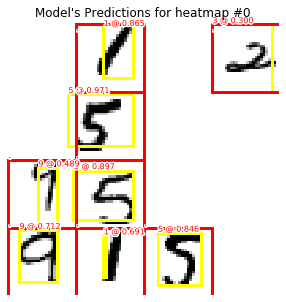

In [20]:
valdata = loaddill('mnist.val.16.data')
val = ImageObjects(valdata)
val_dl = DataLoader(val, batch_size=100, shuffle=True)
ims, clss_tr, regr_tr = next(iter(val_dl))
tr = clss_tr, regr_tr

with torch.no_grad():
    model.eval()
    pr = clss_pr, regr_pr = model(ims)
print(custom_accuracy_multiheatmaps(pr, tr, heatmap_infos))

ix = randint(10)
for hx, heatmap_info in enumerate(heatmap_infos):
    bbs_pr, objs_pr, confs_pr, ancs_pr = HMsToBBsClss(clss_pr[hx][ix], regr_pr[hx][ix], heatmap_info, 
                                                      threshold=0.3, debug=False)
    infos = flatten(zip([f'{obj} @ {conf:.3f}' for obj, conf in zip(objs_pr, confs_pr)], ['' for _ in range(len(ancs_pr))]))
    bb_colors = flatten(zip([(255,255,0)]*len(bbs_pr), [(255,0,0)]*len(ancs_pr)))
    _bbs_ = flatten(zip(bbs_pr, ancs_pr))
    if len(bbs_pr): show(ims[ix,0], bbs=_bbs_, texts=infos, bb_colors=bb_colors,
                         sz=5, th=1, text_sz=8, title=f'Model\'s Predictions for heatmap #{hx}')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor(0.9631, device='cuda:0'), tensor(0.0906, device='cuda:0'))


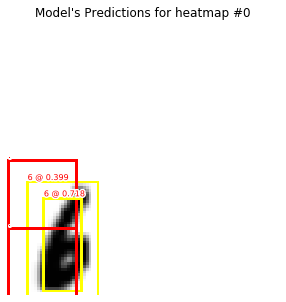

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


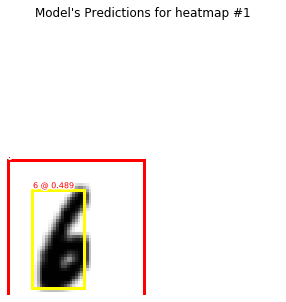

In [21]:
valdata = loaddill('mnist.val.4.data')
val = ImageObjects(valdata)
val_dl = DataLoader(val, batch_size=100, shuffle=True)
ims, clss_tr, regr_tr = next(iter(val_dl))
tr = clss_tr, regr_tr

with torch.no_grad():
    model.eval()
    pr = clss_pr, regr_pr = model(ims)
print(custom_accuracy_multiheatmaps(pr, tr, heatmap_infos))

ix = randint(10)
for hx, heatmap_info in enumerate(heatmap_infos):
    bbs_pr, objs_pr, confs_pr, ancs_pr = HMsToBBsClss(clss_pr[hx][ix], regr_pr[hx][ix], heatmap_info, 
                                                      threshold=0.3, debug=False)
    infos = flatten(zip([f'{obj} @ {conf:.3f}' for obj, conf in zip(objs_pr, confs_pr)], ['' for _ in range(len(ancs_pr))]))
    bb_colors = flatten(zip([(255,255,0)]*len(bbs_pr), [(255,0,0)]*len(ancs_pr)))
    _bbs_ = flatten(zip(bbs_pr, ancs_pr))
    if len(bbs_pr): show(ims[ix,0], bbs=_bbs_, texts=infos, bb_colors=bb_colors,
                         sz=5, th=1, text_sz=8, title=f'Model\'s Predictions for heatmap #{hx}')
